,class,count
0,Amphiprion_clarkii,4049
1,Chaetodon_lunulatus,2534
2,Chromis_chrysura,3593
3,Dascyllus_reticulatus,12112
4,Plectroglyphidodon_dickii,2683


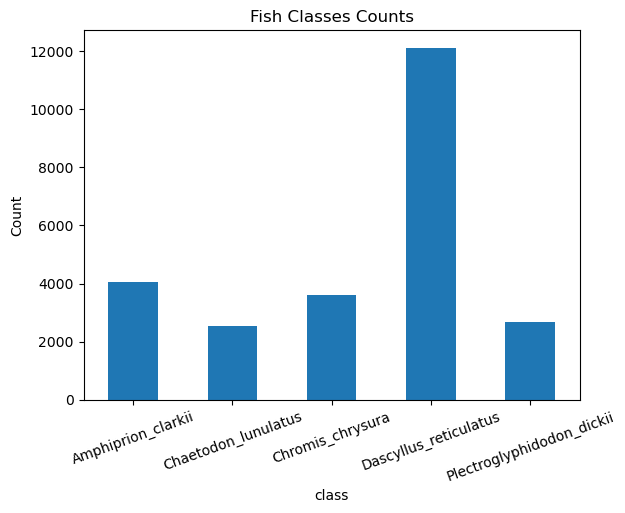

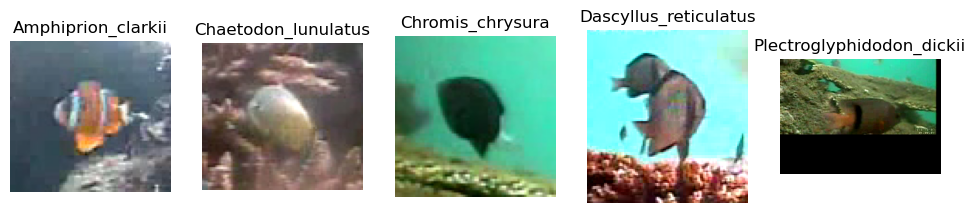

In [1]:
from bd_utils import * #utils.py homemade file
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#Show Data Distribution
p = r"./dataset"
classes = os.listdir(p)

df = pd.DataFrame(columns=["class","count"])

for i in range(0,len(classes)):
    df.loc[i] = [classes[i]] + [len(os.listdir(p+"/"+classes[i]))]
    
display(df)
ax = df.plot.bar(x='class', y='count', rot=20,title = "Fish Classes Counts", ylabel = "Count", legend = 0)

#Show one of each class
plt.figure(figsize=(12, 6))
for i in range(0,len(classes)):
    plt.subplot(1,len(classes),i+1)
    image = mpimg.imread(p+ "/" + classes[i] + "/" + (os.listdir(p+"/"+classes[i])[0]))
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis('off')

In [2]:
imPath_df, dev_df = create_dataframes("fish_labels.txt") # get main dataset and development version (smaller)
#smaller dataset for testing
display(dev_df)

,imP,label
0,./dataset/Amphiprion_clarkii/fish_000000019599...,0
1,./dataset/Amphiprion_clarkii/fish_000000019599...,0
2,./dataset/Amphiprion_clarkii/fish_000000019599...,0
3,./dataset/Amphiprion_clarkii/fish_000000019599...,0
4,./dataset/Amphiprion_clarkii/fish_000000019599...,0
...,...,...
22383,./dataset/Plectroglyphidodon_dickii/fish_00001...,4
22384,./dataset/Plectroglyphidodon_dickii/fish_00001...,4
22385,./dataset/Plectroglyphidodon_dickii/fish_00001...,4
22386,./dataset/Plectroglyphidodon_dickii/fish_00001...,4


In [3]:
#Only FCN
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from keras.layers import Dense, Conv2D, Flatten
from sklearn.utils.multiclass import type_of_target


skf = StratifiedKFold(n_splits=2, shuffle = True, random_state = 123)

X=dev_df.imP
y=dev_df.label
y=y.astype('int') 


gt = [] #ground truth (appended on each fold)
results = [] # validation results (appended on each fold)


#stratified split
for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    
    X_train_im = np.array(path2im(X_train))
    X_test_im = np.array(path2im(X_test))
    
    y_train = process_labels(y_train)
    y_test = process_labels(y_test)
    
    
    train_generator = DataGenerator(X_train_im, y_train, batch_size = 10)
    val_generator = DataGenerator(X_test_im, y_test, batch_size = 10)
    
    #create model
    model = tf.keras.models.Sequential()
    #add model layers
    model.add(tf.keras.Input(shape=(64,64,3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    
    #set optimiser
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_generator ,verbose=1, epochs=5, validation_data = val_generator)
    
    
    y_pred = model.predict(X_test_im)
    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1) #convert back from one-hot
    #add to arrays for confusion matrix
    gt = np.append(gt , y_test)
    results = np.append(results , y_pred)
    
    #get confusion matrix by adding actual and predicted on each run

0it [00:00, ?it/s]

Epoch 1/5
25/25 [==============================] - 3s 10ms/step - loss: 1.4453 - accuracy: 0.4840 - val_loss: 1.2843 - val_accuracy: 0.4960
Epoch 2/5
25/25 [==============================] - 0s 5ms/step - loss: 0.4436 - accuracy: 0.8720 - val_loss: 1.1886 - val_accuracy: 0.5640
Epoch 3/5
25/25 [==============================] - 0s 5ms/step - loss: 0.1299 - accuracy: 0.9800 - val_loss: 0.9828 - val_accuracy: 0.7400
Epoch 4/5
25/25 [==============================] - 0s 4ms/step - loss: 0.0540 - accuracy: 1.0000 - val_loss: 1.1251 - val_accuracy: 0.7080
Epoch 5/5
8/8 [==============================] - 0s 0s/step


1it [00:06,  6.33s/it]

Epoch 1/5
25/25 [==============================] - 0s 9ms/step - loss: 1.6967 - accuracy: 0.4120 - val_loss: 1.2250 - val_accuracy: 0.6600
Epoch 2/5
25/25 [==============================] - 0s 5ms/step - loss: 0.5528 - accuracy: 0.8240 - val_loss: 1.0525 - val_accuracy: 0.7120
Epoch 3/5
25/25 [==============================] - 0s 5ms/step - loss: 0.1578 - accuracy: 0.9720 - val_loss: 0.9362 - val_accuracy: 0.7760
Epoch 4/5
25/25 [==============================] - 0s 4ms/step - loss: 0.0629 - accuracy: 1.0000 - val_loss: 0.7698 - val_accuracy: 0.8440
Epoch 5/5
8/8 [==============================] - 0s 2ms/step


2it [00:08,  4.12s/it]


Accuracy: 0.82
Average Precision: 0.8413129437401283
Average Recall/Sensitivity: 0.82
Average Specificity: 0.9550000000000001
Average F1 Score 0.7984502389293147
Average Cohen K 0.7580199497143686


<Figure size 2000x2000 with 0 Axes>

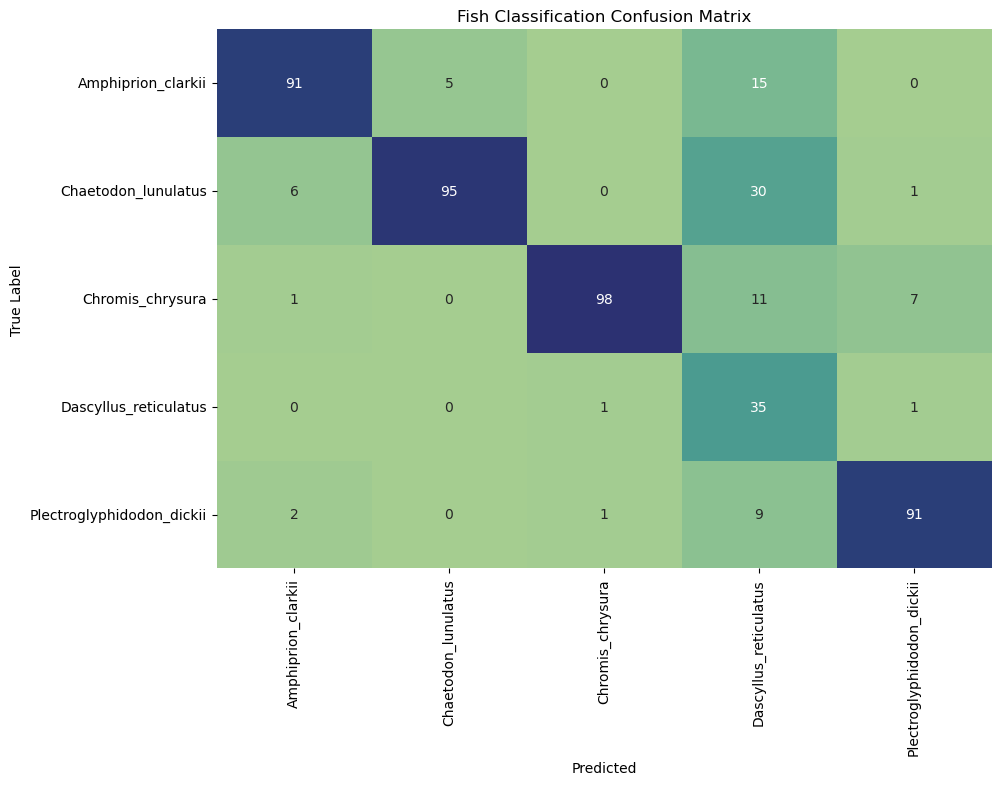

In [4]:
#get per class confusion matrix and calculate metrics
get_metrics(gt,results)
#Show confusion matrix
create_conf(df,gt,results)